# Chapter 13. 어텐션(Attention)과 트랜스포머 

### 1. Seq2Seq: 변역에서 시작한 딥런이 기법
* 난이도 : 문서 분류 < 번역
    * 문서 분류 - 하나의 결론 
    * 번역은 단어들을 순차적으로 생성해야 하기 때문
        * 특히, 단어들의 길이: 가변적 
        * 입력으로 일련의 단어 -> 다시 일련의 단어들 생성 (seq2seq)
        * I went to school yesterday 
            * 문장에 대한 내용을 이해하고, 정해진 형태(벡터)로 이해된 내용을 저장 
            * 이것을 기반으로 먼저 번역의 첫 단어를 예측
            * 1번째 단어 예측 
                * 번역 학습 하면서 구성한 한글 사전에 있는 모든 단어에 대한 확률 계싼 
                * 그중 가장 높은 확률인 단어를 제안 
                * 그 단어: '나는'
            * 2번째 단어 예측 
                * '나는'을 이용해 다음 단어를 예측 
                * 사전에 있는 모든 단어들에 대한 확률이 높은 단어 선정 
            * 이러한 작업 반복 -> '나는 어제 학교에 갔다' 
            * 영어, 한글 어순 달라서 단순히 단어를 순서대로 번역 X 
                * 문장에 대해 이해한 내용을 지정한 형태로 저정해야 함 
            * BOW 기반의 기법: 번역 불간으 
            * 단어 수준에서 예측 이루어짐, 워드 임베딩 필수적 

* 번역 문제: 시계열 분석과 유사함 
    * ex. 10일의 주기 이용해 다음 5일 주기 예측 
        * 10일의 주가로 첫날의 주가를 예측 
        * 둘째 날은 첫날의 주가를 이용해서 예측
        * 맨 앞의 주가 하나를 버리고 앞 9일의 주가와 예측된 첫날의 주가로 10일의 입력집합 만듦 
        * 둘째 날을 예측 
        * 즉, 5일의 주가를 예측하려면 5번의 입력집합 만들고 5번 예측 해야함 
    * ex. 입력은 10개의 숫자로 이루어진 시퀀스가 되고, 출력은 5개의 시퀀스 
    * ex. 10개의 단어로 이루어진 영어 문장 -> 5개의 단어로 이루어진 한국어 문장으로 번역    
---

* Seq2Seq 문제 
    * 가장 단순한 딥러닝 모형은 RNN(Recurrent Neural Networks)
    * RNN에 기반한 seq2seq 모형 
    * Encoder (인코더)
        * Hello, world, <end>
        * 영어 문장을 이해하는 역할 
        * 인코더 부분의 입력은 번역하고자 하는 영어 문장
        * 은닉층을 통해 앞 단어로부터 순차적으로 정보가 축적되고 
        * 마지막<end> 입력을 받은 은닉층의 노드는 영어 문장 전체의 문맥정보 내포 
        * 이때 <end>는 문장의 마지막 나타냄 
        * 실제 은닉층에 들어가는 입력인 hello, world 등은 임베딩한 벡터로 변환됨 
        * 앞 단어부터 문맥 정보를 축적하는 역할 
        * 정방향 RNN을 표현하고 있음

    * Decoder (디코더)
        * boujour<start> le monde <end>
        * 은닉층의 출력은 사전에 있는 단어로부터 하나를 선택하는 문제/ 원핫벡터 
        * Encoder의 문맥 정보를 통해 프랑스어 문장을 생성하는 역할
        * <start> 는 문장의 시작 혹은 번역의 시작을 알리는 벡터 
        * 시작신호와 그 전까지 축적된 문맥정보로 첫 단어 bonjour 예측
        * 이 bonjour는 다음 입력값으로 사용됨 
        * --> 출력이 바로 입력으로 연결됨 
        * --> 디코더는 한 번에 실행되지 않고, 각 단어를 예측하는 단계까 순차적으로 실행됨

* 인코더 문맥정보 축적, 디코더는 이 문맥정보에 자신이 생성한 단어들 하나씩 결합하면서 다음 단어 예측 
* 이 과정에서 모형을 이용한 예측은 한 번이 아니라 생성해야 할 단어의 수만큼 반복적으로 이루어짐 
* 디코더가 문장의 끝을 알리는 <end> 를 생성하면 번역을 마침 
* 모형이 '갔다'라는 단어를 생성했다면 그 다음에는 문장이 종료된 가능성이 높음을 알 수 있음 
--- 

### 2. 어텐션을 이용한 성능의 향상 
* seq2seq 모형 성능 제약 조건 
    * 문맥 정보가 인코더의 마지막 벡터 하나에 집중되는 현상 
    * 이 하나의 벡터에 번역할 문장의 모든 문맥 정보가 포함됨 
    * 이를 이용해 디코더는 반복적으로 다음 단어를 예측함
    * 번역할 문장이 수백 단어로 이루어진 긴 문장이라면 
        * 하나의 벡터에 많은 정보가 잘 축적되고, 또 이를 디코더에 잘 풀어낼 수 없음 
        * 번역의 성능이 떨어짐 
        * LSTM, 양방향 LSTM 을 활용하면 더 나은 결과 
        * But, 'I went to school yesterday'번뎍 
            * 모든 문맥정보는 인코더 마지막 하나의 벡터에 축약 
            * 이를 이용해 '나는 어제 학교에 갔다'의 모든 단어 예측 
            * 이때, 두 번째 단어인 '어제'를 예측할 때, 
            * 이 단어에 가장 많은 영향을 미치는 원문의 단어 -> 'yesterday' 
            * 그러나, 이 정보에 다른 단어들과 함께 문맥 벡터에 숨어 있음 
            * 딥러닝의 특성을 통해 'yesterday' <-> '어제'예측 직접 관여하도록 함 
                * --> Attention mechanism 
---

* 'hello world' -> 'bonjour le monde'
    * 'bonjour'를 예측하는 과정 / 어텐션 메커니즘 적용 
        * 아래 부분 - seq2seq 모형과 동일하게 흘러감 
        * 인코더 윗부분 - 컨텍스트 벡터(context vector) 
            * 이 벡터는 첫 단어의 예측에 가장 많은 영향을 미치는 단어에 대한 정보가 담김 
            * 단어별로 계산된 어텐션 스코어에 대해 소프트맥스를 적용한 가중치 표현됨 
            * 이 값들이 바로 각 단어가 bonjour 에 미치는 영향의 비중이 됨 
            * 이 값은 학습을 통해 결정되며, 현재의 값 bonjour 에는 hello 가 가장 큰 영향을 미침 

* 컨텍스트 벡터 
    * 단어들의 임베딩 벡터에 대해 가중치를 반영해 가중 합계를 구하면 컨텍스트 벡터가 됨 
    * 인코더의 마지막 벡터 + 디코더의 입력값 합쳐져 --> 첫 단어를 생성 
    * 기존의 seq2seq 모형 + 어텐션 메커니즘에 의한 컨텍스트 벡터 추가 -->  번역할 단어 예측 
    * 예측할 단어의 순서에 따라 계속 바뀜 
    * Seq2Seq 모형과 어텐션 메커니즘에 대한 이해 -> BERT 모형의 이해 

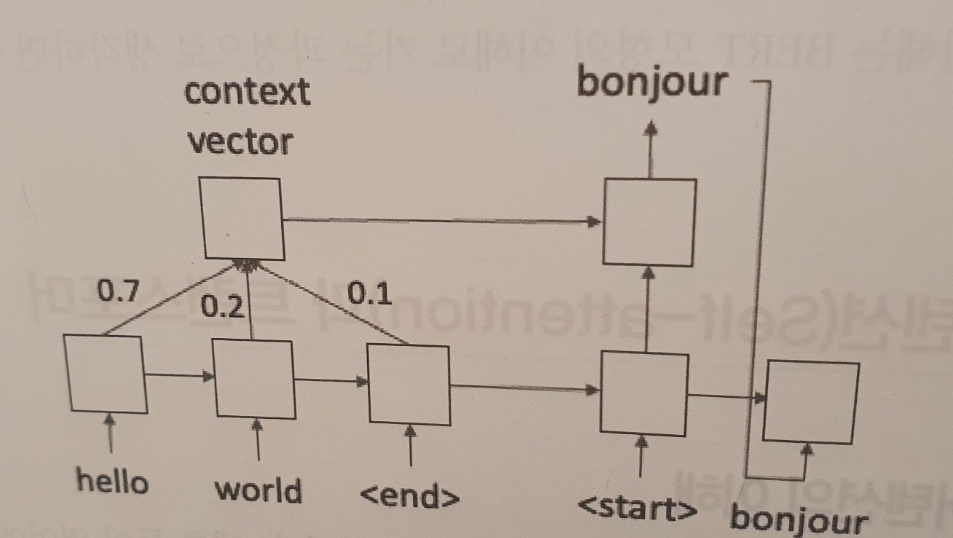

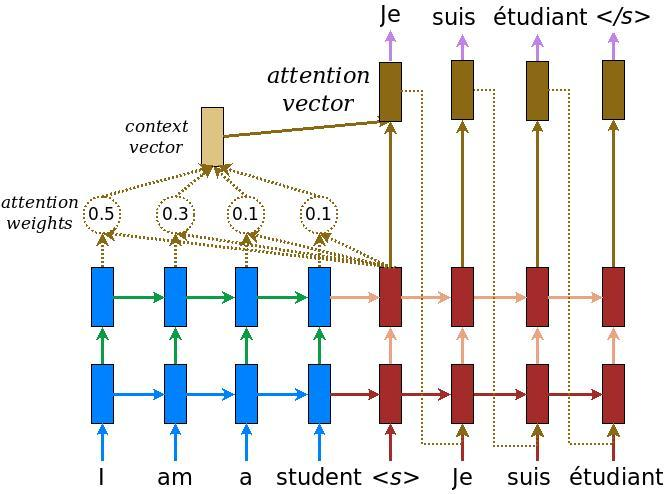

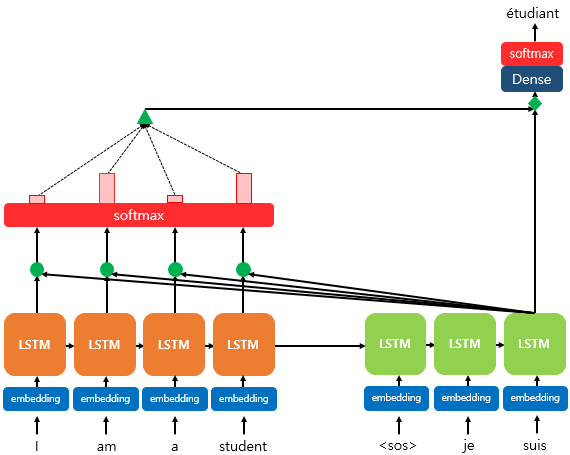

In [5]:
from IPython.display import Image
display(Image('./img/ch13/bookattention.jpg'))
display(Image('./img/ch13/attention.PNG'))
Image('./img/ch13/dotproductattention.PNG')

### 3. 셀프 어텐션(Self-Attention)과 트랜스포머
* 1. 셀프 어텐션의 이해 
    * 어텐션 - 인코더 + 디코더 
    * 영어 -> 한글 
        * 단어에 직접적인 영향을 미치는 영어 단어에 대한 정보 중요 
        * 셀프 어텐션 
            * 같은 문장 내에서의 어텐션 
            * ex. The animal didn't cross the street because it was too tired 
                * --> it 의미하는바 / 문장을 통해 -> animal 파악 
            * ex. The animal didn't cross the street because it was too wide 
                * --> it 의미하는바 / 문장을 통해 -> the street 파악 
            * 동일한 단어, 문맥에 따라 다른 의미 가짐 
            * 그 의미에 영향을 미치는 단어가 문장에 존재 

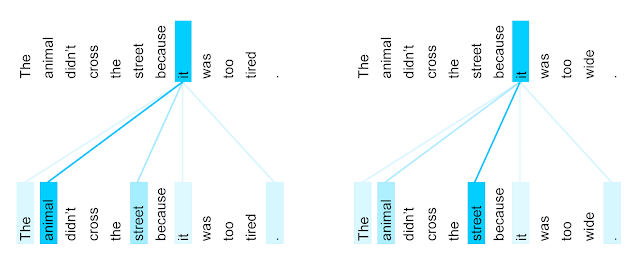

In [6]:
display(Image('./img/ch13/self_attention.PNG'))

* seq2seq
    * 인코딩 과정 
        * 문장의 앞에서부터 순차적으로 정보가 축적됨 
            * --> 어떤 단어에 대해 **직접적으로 영향을 미치는 단어**에 대한 정보는 포함되기 어려움 
        * 양방향 LSTM 을 사용한다면, 반대편으로도 정보가 축적 
            * --> But, **직접적인 영향을 미치는 단어** 선별해 정보를 축적하지 않는다 

* self- attention 
    * 같은 문장 내에서의 단어 간 영향을 표현하는 것 
    * 어떤 단어를 벡터로 임베딩할때, 그 단어에 영향을 미치는 다른 단어들의 정보를 함께 인코딩 
    * --> 각 단어들에 대해 **그 단어에 영향을 미치는 단어들의 정보** 선별해 자신에게 축적 
    * 각 단어 모두 
        * 자신에게 오는 어텐션에 대한 정보 갖고 있음 
            * <-> RNN  또는 LSTM에 기반한 seq2seq와 달리 
            * <-> 어느 한 벡터가 전체 문맥에 대한 정보 축적 X 
    * 인코딩 과정에서 문맥에 대한 정보는 각 단어에 골고루 분포 
    * 디코딩 과정에서 입력 문장의 모든 단어의 임베딩 벡터를 어텐션 형태로 활용 
    ---

* 2. 트랜스포머의 구조 
    * BERT (Bidirectional Encoder Representations from Transformers)
    * 트랜스포머를 기반으로 만들어진 모형 
    * 트랜스포머에서 인코더 부분만 따로 떼어 학습한 모형 

* 트랜스포머 
    * 번역을 이해 개발된 모형 
    * 논문(성능기준) : 영어-> 독일어, 프랑스어로 번역한 결과
    * 셀프 어텐션을 통해 구현함 
    * 'Attention is all you need' 
        * 기존 seq2seq 모형에서 RNN/LSTM 기반 구조 버리고 
        * 오직, 어텐션만 의지한 모형 제안 

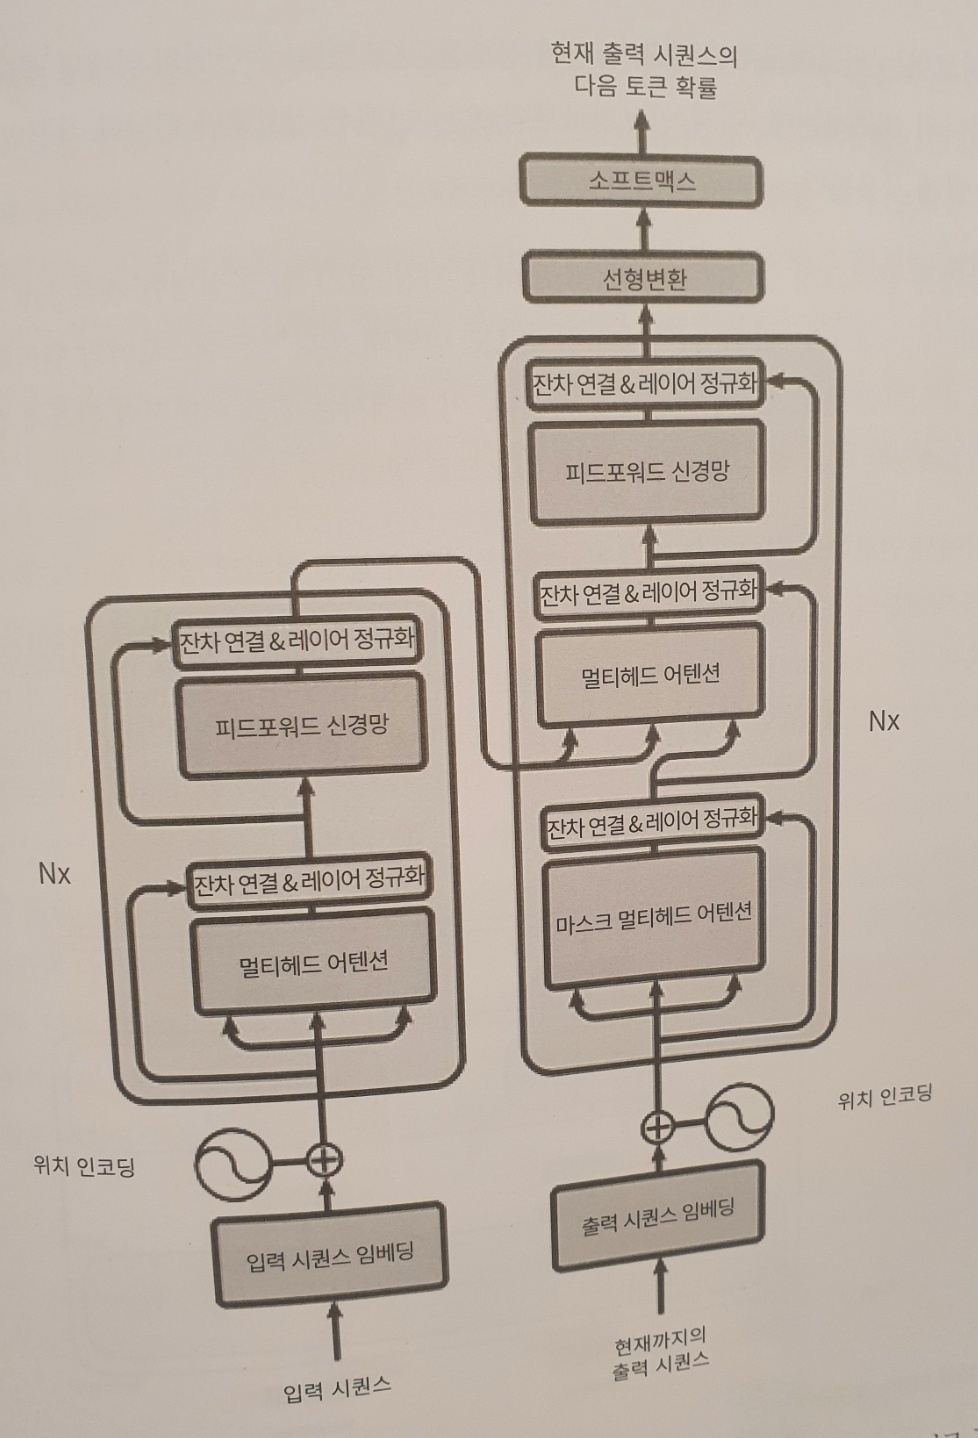

In [11]:
display(Image('./img/ch13/transformer.jpg', width =500 , height= 600))

* 트렌스포머 구조 
    * 기존의 seq2seq와 동일하게 인코더 + 디코더로 구성됨 
    * 인코더 
        * 번역의 대상이 되는 문장을 입력받음 
        * 문맥 정보, 즉 셀프 어텐션 정보를 추출 
    * 디코더    
        * 인코더로부터 셀프 어텐션 정보를 갖고 있는 각 단어이 임베딩 벡터 이용 
        * 단어를 하나씩 예측함 
        * 이때 인코더로부터 오는 어텐션 정보 + 자신의 셀프 어텐션 정보 함께 사용 
    *  Jay Alammar 의 'The Illustrated Transformer' 
        * https://nlpinkorean.github.io/illustrated-transformer/
        * 인코더& 디코더 
    * Nx 
        * 생긴 층의 N개가 겹쳐 있다는 것을 의미

* ELMo
    * Bi-LSTM 층이 두 개 사용된 것처럼 
    * 트랜스포머에서도 층이 여러개 사용될 수 있음 
    * 하나의 층
        * 멀티헤드 셀프 어텐션(Multi-Head Attention)
        * 피드포워드 층으로 구성 

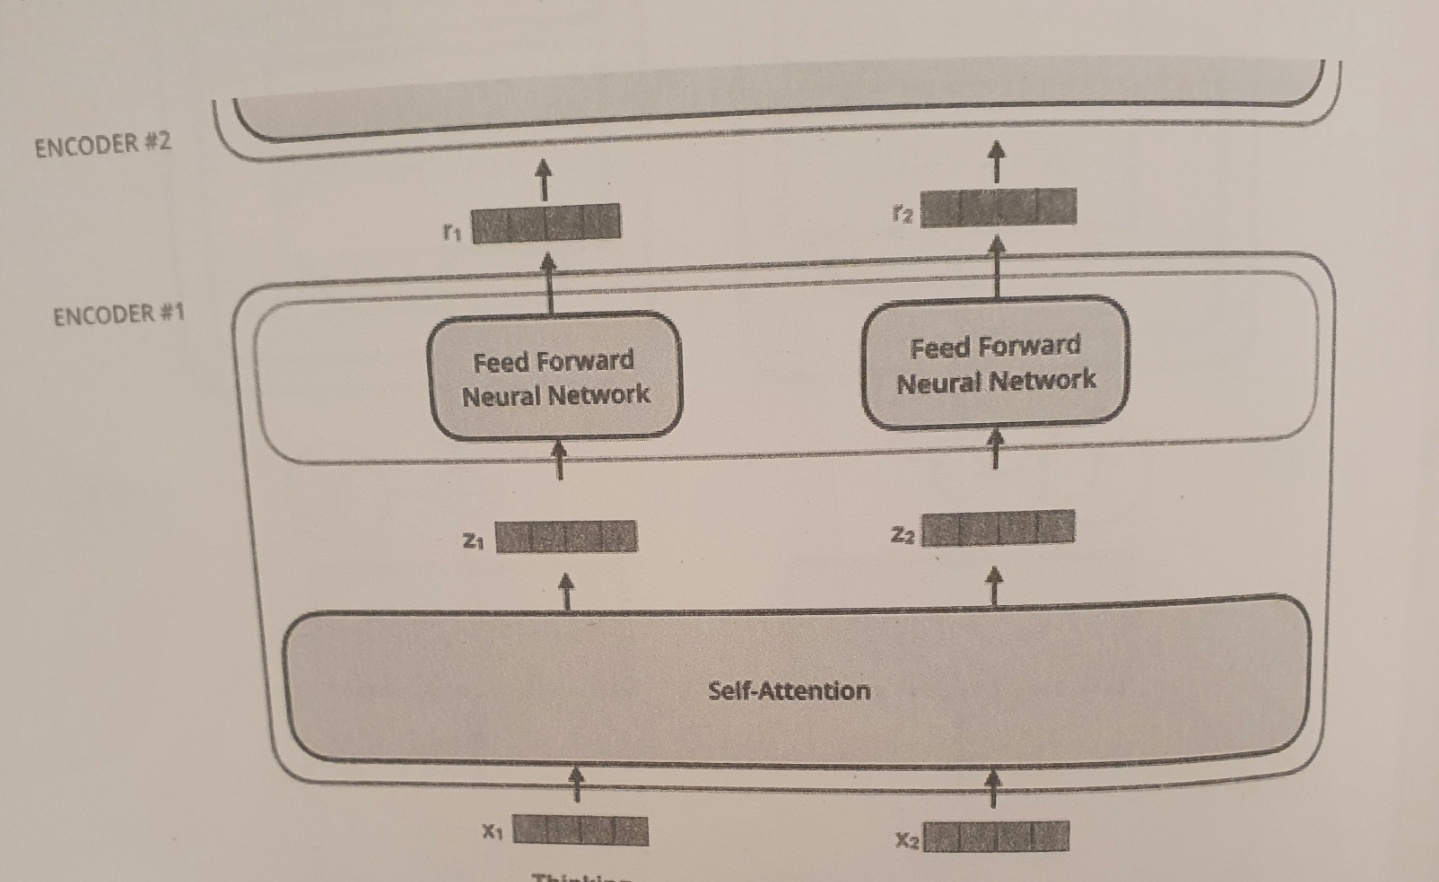

In [17]:
display(Image('./img/ch13/encoder.jpg', width= 600 , height= 400))

* 셀프 어텐션 층 
    * 각 단어들(x1,x2)을 입력으로 받음 
    * 각 단어에 대응하는 결과 (z1,z2) 출력 
    * 층을 거치더라도 단어들이 합쳐져 하나의 벡터 X 
    * 각 단어들이 계속 유지됨 
    * --> 모든 단어에 대해 그 단어에 영향을 미치는 다른 단어들의 정보를 결합 
    * 나에게 영향을 미치는 단어가 얼마나 많이 영향을 미치는가 
        * --> 결합되는 단어의 정보 크기를 조절하여 합침 
        * ex. z1
            * Thinking 에 영향을 미치는 단어들의 정보가 결합돼 있다고 할 수 있음 
* 피드포워드 층
    * 단어별로 분리돼 있어 단어들 간의 정보가 결합되지 X
    * 최종 목적에 맞게 학습이 되는 가중치에 의해 z의 특성을 변형 -> r 출력 
    * 출력된 (r1,r2)는 다음 인코딩 
    ---

* 3. 인코더의 셀프 어텐션 원리
    * 셀프 어텐션의 원리

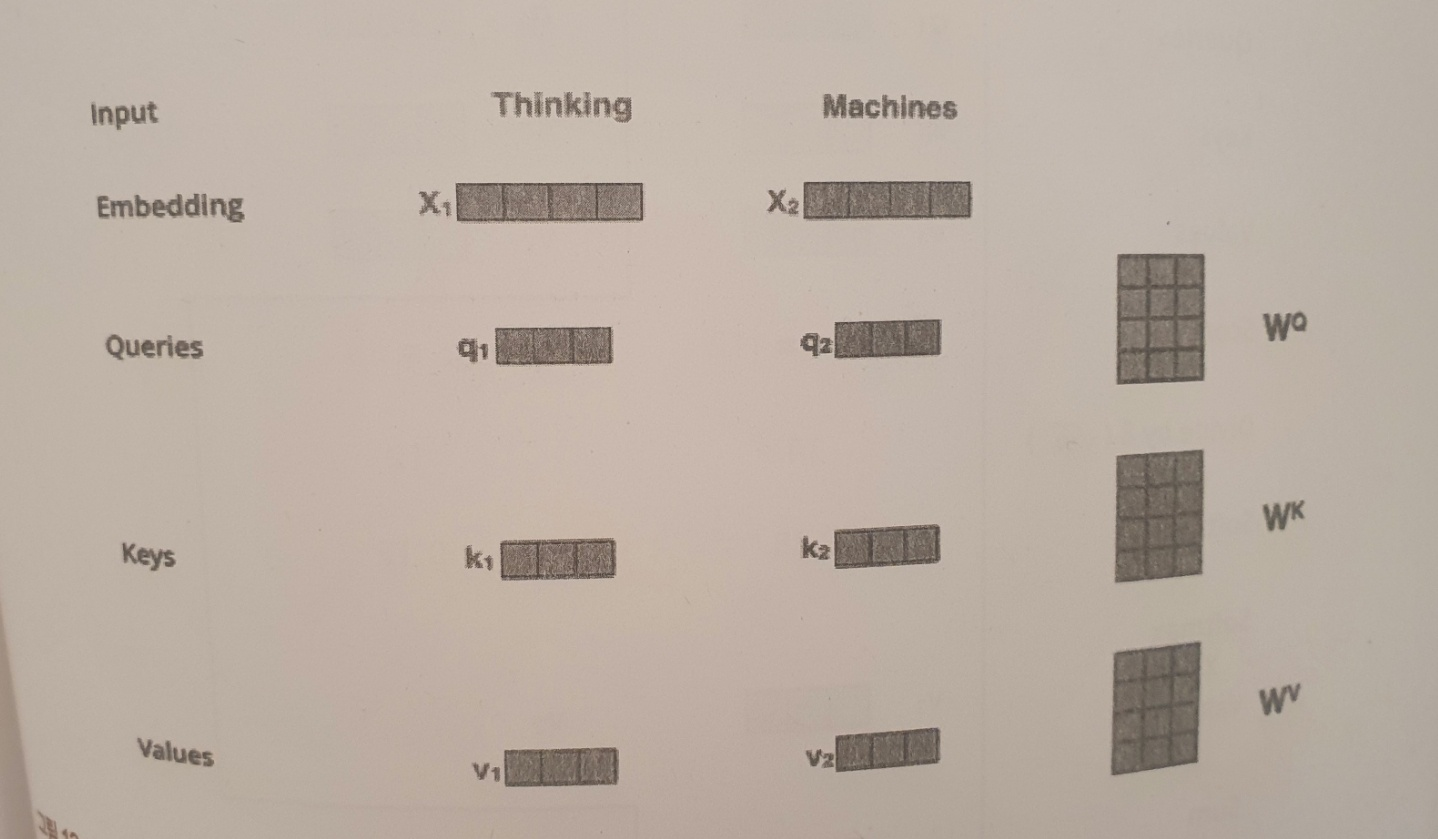

In [18]:
display(Image('./img/ch13/self_attention.jpg', width= 600 , height= 400))

* 셀프 어텐션의 원리
    * query, key, value 세 개의 벡터를 이용해 계산됨 
    * 입력- 단어의 임베딩 벡터로부터 각각의 가중치 행렬 Wq,Wk,Wv
    * 이 세 벡터의 초깃값 
        * 원래 단어의 정보 내포 
    * query 
        * 어텐션을 받은 단어가 어텐션과 관련해 다른 단어들에게 던지는 질문 
        * ex. A -> 다른 단어 
            * ex. 나에게 영향을 많이 미치는 단어는 누구? 
    * key 
        * 그에 대한 대답
        * ex. 내가 상당히 많은 영향을 끼치고 있습니다.  
    * value 


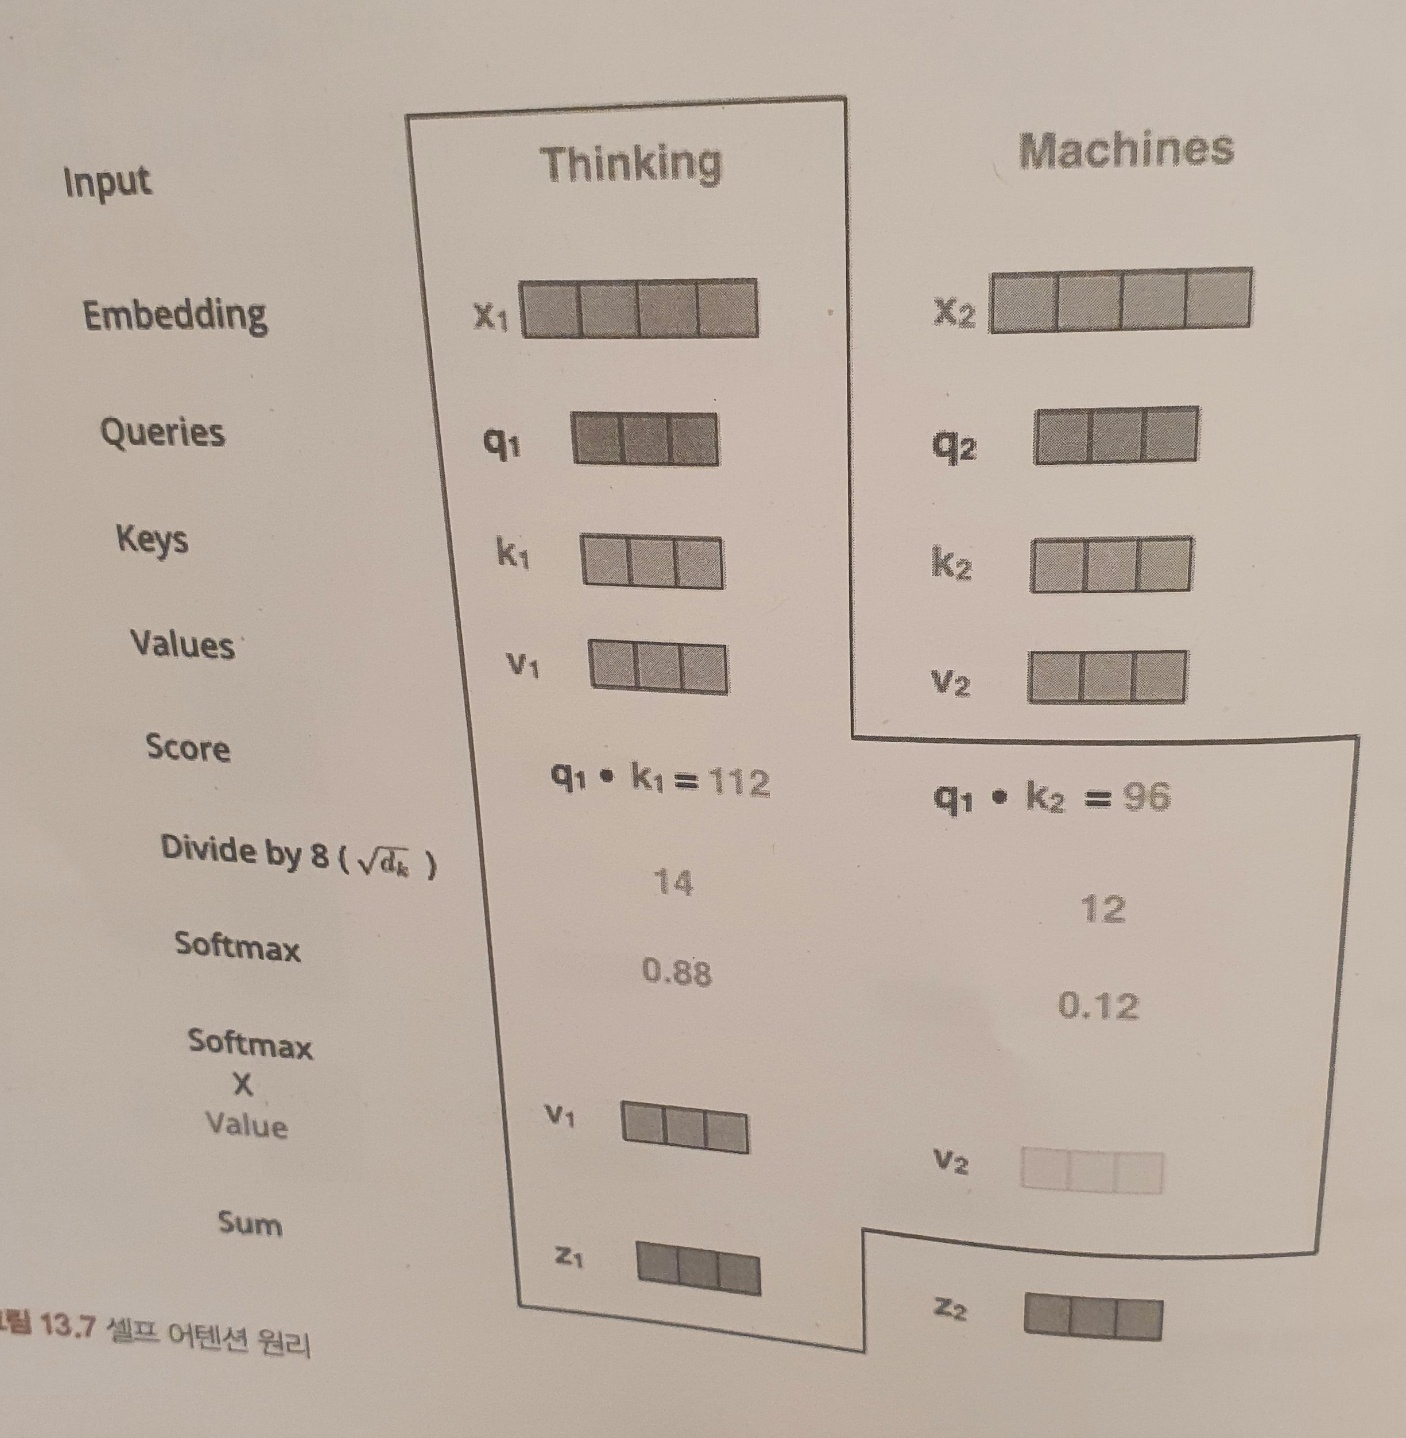

In [21]:
display(Image('./img/ch13/self_attention_mechanism.jpg', width= 800 , height= 600))

* 셀프 어텐션 계산하는 과정 
    * x1
        * x2에 영향을 받는다면 
        * x1이 던진 질문 q1과 -> k2는 서로 비슷한 값 갖도록 학습 
        * q1과 k2는 Wq, Wk 가중치에 의해 변환된 결과 
        * 가중치 학습에 의해 결정됨 
        * x1이 x2에 영향을 받는 정도 계산
            * (q1 x k2) 내적 
            * 영향의 정도가 클수록 두 값은 비슷해지고 내적값은 커짐 
        * x1 이 x3에 영향 받는 정도 
            * (q1 x k3) 내적
            * x1을 기준으로, q1과 자신을 포함한 다른 단어들의 k를 내적 
            * 자신에게 오는 영향의 정도를 계싼 
            * 이 값을 확률로 변환 
            * 영향을 주는 단어들의 v 
                * w, 즉 본래 단어들의 정보와 각각 곱하면 
                * 나에게 영향을 미치는 다른 단어들의 정보를 / 영향의 정도에 따라 조절한 결과 
                * + 조절된 정보량 (x1에 대한 어텐션 벡터)
        * 어텐션 벡터 
            * --> 나이게 영향을 미치는 단어들의 정보를 결합한 것 
            * 나에게 가장 영향을 미치는 단어 
                * --> 나 자신일 가능성이 높다 
                * --> 자신 외에 나에게 영향을 미치는 단어들의 정보가 포함되며 
                * --> 문장의 의미적 구조인 문맥을 차츰 파악  

* 트랜스포머 
    * 인코더 층을 병렬로 연결한 멀티헤드 어텐션 사용 
    * 멀티헤드 
        * 어텐션을 다양한 관점에서 계산하고 이를 결합 
        * CNN(Convolutional Neural Networks)와 유사 
            * 채널(다양한 관점)을 통해 
            * 이미지를 해석하고 
            * 이를 다시 결합하는 과정과 유사 
        * 동일한 문장에 대해 여러 관점으로 어텐션을 해석 
        * 이러한 여러 관점을 다시 결합해 최종 출력 만듦 
        * 의견 다른 관점으로 문장 해석, 취합하는 과정 

    * 6개의 인토더층, 디코더층 사용 
    * 여러 층을 통해 깊게 어텐션 학습 
    * 많은 시간과 자원 소모, 적절한 수의 층 필요 
---

* 4. 디코더의 작동 원리 
    * 인코더 vs 디코더 
        * 1. 디코더, 인코더로 향하는 멀티헤드 어텐션 층이 하나 더 있음 
        * 2. 디코더의 셀프 어텐션층
            * 인코더와 달리 Masked 추가 
    * 디코드 구조 
        * 셀프 어텐션 층 +(어텐션층)+ 피드 포워드 층 
            * (어텐션 층)
                * 인코더-디코더 구조에서 인코더 -> 디코더로 향하는 어텐션 
                * 셀프 어텐션과 동일한 메커니즘 적용 
                * query 를 던지는 단어는 디코더에서 생성하고 있는 단어 
                * 즉, 영어 -> 한국어로 번역 
                    * 디코더에서 생성한 한글 단어가 query를 던지고 
                    * 이에 대해 key와 value는 인코더에 있는 영어 단어로부터 옴 
                    * 한국어 단어에 영향을 미치는 영어 단어들의 영향력을 표현 (인코더-디코더)
                    * 생성되고 있는 한국어 단어에 대한 어텐션 정보
                        * 인코더에 있는 영어 단어로부터 와야 함 
        * 디코더이 셀프 어텐션 
            * Masked 
                * 디코더의 특성산 셀프 어텐션이 뒤에서 앞으로 갈 수 없기 때문에 만들어짐 
                * seq2seq 처럼, 디코더는 한 번에 모든 단어들 생성 X, 하나의 단어 반복해 생성 
                * 디코더가 실행 
                    * 번역의 첫 단어를 생성 
                    * 다음, 처음 생성된 단어 정보 이용해 둘째 단어 생성 
                        * 첫째 단어 -> 둘째 단어 영향 
                        * 현재 생성하고자 하는 단어 
                            * 미래에 생성할 단어로부터 어텐션을 받지 X 
                            * --> Masked
                            * --> 디코더에서 순방향으로만 어텐션이 향하는 것을 구현한 매커니즘 
    * 디코더 
        * 토큰 생성될 때까지 반복해 단어를 생성 
        * 작동이 끝나면 문장이 만들어짐 
        * 트랜스포머 보다 BERT가 더 많이 사용됨 
        * BERT 대신 트랜스포머 모형 사용하기도 함 
        